<a href="https://colab.research.google.com/github/adhamarif/pneumonia-prediction/blob/main/pneumonia_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## The Dataset

Similar to former notebooks where we worked with the [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315), where here have a smaller X-ray dataset containing 5856 images.
Instead of 14 different diseases we will here concentrate on much fewer possible labels so that *hopefully* the number of images is enough to train good deep learning classifiers.

The images are distributed accross two folders (`NORMAL` and `PNEUMONIA`), the related metadata can be found in `x_ray_metadata_portfolio.csv` but actually also is reflected in the image file names.

## Import metadata

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Import the libraries
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/ChestXray_pneumonia_prediction.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content') #Extracts the files into the /tmp folder, can try to extract in content folder --> easier
zip_ref.close()

In [5]:
os.getcwd()

'/content'

In [6]:
path_data = "/content/ChestXray_pneumonia_prediction - Copy/"
#path_data = "datasets/ChestXray_pneumonia_prediction/"
metadata = pd.read_csv(os.path.join(path_data, "x_ray_metadata_portfolio.csv"))

In [7]:
# Add new column that has full path to the image
metadata["filename"] = metadata["folder"] + r"/" + metadata["image"]

# Define the mapping dictionary
label_mapping = {"normal": 0, "pneumonia": 1}

# Create a new column 'label_numerical' using the mapping
metadata["label"] = metadata['label'].map(label_mapping)

# Change infection type to one hot encoding
one_hot = pd.get_dummies(metadata["infection_type"])

# Concatenate the metadata with the one hot encoding
metadata["virus"] = one_hot["virus"]
metadata["bacteria"] = one_hot["bacteria"]
metadata["none"] = one_hot["none"]

# remove infection_type column with string values ---> data leakage
metadata = metadata.drop("infection_type", axis="columns")

### comment
Changes to the data:
1. Change label for pneumonia to numerical (1 - pneumonia, 0 - normal)
2. make the `infection_type` as one hot encoding
3. Only include virus and bacteria as further label, because there is pattern that normal in `label` --> none in `infection_type`

In [8]:
metadata

,patient_id,label,folder,image,filename,virus,bacteria,none
0,0001,0,NORMAL,IM-0001-0001.jpeg,NORMAL/IM-0001-0001.jpeg,0,0,1
1,0003,0,NORMAL,IM-0003-0001.jpeg,NORMAL/IM-0003-0001.jpeg,0,0,1
2,0005,0,NORMAL,IM-0005-0001.jpeg,NORMAL/IM-0005-0001.jpeg,0,0,1
3,0006,0,NORMAL,IM-0006-0001.jpeg,NORMAL/IM-0006-0001.jpeg,0,0,1
4,0007,0,NORMAL,IM-0007-0001.jpeg,NORMAL/IM-0007-0001.jpeg,0,0,1
...,...,...,...,...,...,...,...,...
5851,person99,1,PNEUMONIA,person99_virus_183.jpeg,PNEUMONIA/person99_virus_183.jpeg,1,0,0
5852,person9,1,PNEUMONIA,person9_bacteria_38.jpeg,PNEUMONIA/person9_bacteria_38.jpeg,0,1,0
5853,person9,1,PNEUMONIA,person9_bacteria_39.jpeg,PNEUMONIA/person9_bacteria_39.jpeg,0,1,0
5854,person9,1,PNEUMONIA,person9_bacteria_40.jpeg,PNEUMONIA/person9_bacteria_40.jpeg,0,1,0


In [9]:
print(f"Number of patient in the dataset: {len(metadata.patient_id.unique())}")
print(f"Number of X-Ray images in the dataset: {len(metadata)}")

Number of patient in the dataset: 2790
Number of X-Ray images in the dataset: 5856


In [10]:
metadata.patient_id.value_counts()

person23      31
person124     20
person441     18
person30      15
person1320    14
              ..
person1580     1
0907           1
person1579     1
person1577     1
0001           1
Name: patient_id, Length: 2790, dtype: int64

### Comment:
We have 2790 patients but 5856 X-ray images. This indicates that some patient have more than only one X-ray images. We need to split the datasets based on `patient id` so prevent data leakage in the training.

### 1. load and inspect the data
- **what are missing/problematic entries?**
    - We have no NaN entry. The data is consistent across all the features/columns. The is no problematic entries

In [11]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  5856 non-null   object
 1   label       5856 non-null   int64 
 2   folder      5856 non-null   object
 3   image       5856 non-null   object
 4   filename    5856 non-null   object
 5   virus       5856 non-null   uint8 
 6   bacteria    5856 non-null   uint8 
 7   none        5856 non-null   uint8 
dtypes: int64(1), object(4), uint8(3)
memory usage: 246.0+ KB


### 2. data exploration and cleaning
  - so far everything seems to be OK. let's just keep the data as it is.
  - Update: new column added, named `filename` for the full path to the images in the directory
  - Add new column, that has numerical values for the label
<br>
<br>
  - There is imbalanced ratio between `label` ratio, almost (1:3), but it is well distributed for the `infection_type`. The possible solution would be add class weight for the `label` during the training.

In [12]:
metadata.label.value_counts()

1    4273
0    1583
Name: label, dtype: int64

In [13]:
metadata[["virus", "bacteria", "none"]].value_counts()

virus  bacteria  none
0      1         0       2780
       0         1       1583
1      0         0       1493
dtype: int64

In [14]:
unique_patient_id = metadata.patient_id.unique()

dev_ids, test_ids = train_test_split(unique_patient_id, test_size=0.15, random_state=0)
train_ids, val_ids = train_test_split(dev_ids, test_size=0.15, random_state=0)

In [15]:
# Inspect the partition
len(train_ids), len(val_ids), len(test_ids)

(2015, 356, 419)

In [16]:
train_df = metadata[metadata['patient_id'].isin(train_ids)]
val_df = metadata[metadata['patient_id'].isin(val_ids)]
test_df = metadata[metadata['patient_id'].isin(test_ids)]

In [17]:
# Inspect the partition
len(train_df), len(val_df), len(test_df)

(4173, 809, 874)

In [18]:
# Inspect the partition if it's actually splitted by IDs
len(train_df.patient_id.unique()), len(val_df.patient_id.unique()), len(test_df.patient_id.unique())

(2015, 356, 419)

In [19]:
train_df["label"].value_counts(normalize=True)

1    0.725617
0    0.274383
Name: label, dtype: float64

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize images
image_generator = ImageDataGenerator(
    rescale=1.0/255
)

# Pick your label column(s)
label_column = ["label"]

# Calculate class weights
class_weights = dict(1 / train_df[label_column].value_counts(normalize=True))

# Define the data generators
train_generator = image_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=path_data,
    x_col="filename",
    y_col=label_column,
    target_size=(320, 320),
    batch_size=32,
    class_mode="raw",
    color_mode= "rgb",
    class_weight=class_weights  # Specify class weights
)

val_generator = image_generator.flow_from_dataframe(
    dataframe=val_df,
    directory=path_data,
    x_col="filename",
    y_col=label_column,
    target_size=(320, 320),
    batch_size=32,
    class_mode="raw",
    color_mode="rgb",
    shuffle=False,  # this is crucial for later evaluation!
)

Found 4173 validated image filenames.
Found 809 validated image filenames.


In [21]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Model

inputs = Input(shape=(320, 320, 3)) # resolution, greyscale
x = Conv2D(32, (3, 3), activation="relu")(inputs) # 32 kernels, with size 3x3
x = MaxPooling2D((2, 2))(x) #dimension size for comparison
x = Conv2D(64, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)

# Dense (decision) part
x = Flatten()(x)
x = Dense(64, activation="relu")(x) # dont put too big values, because it will amplify the parameter values
outputs = Dense(1, activation="sigmoid")(x) # predict one class, "linear", "relu", "softmax" for multiclass

model = Model(inputs=inputs, outputs=outputs) # model need what is the input and output based on keras layer
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 320, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 318, 318, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 159, 159, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 157, 157, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 78, 78, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 76, 76, 128)       73856 

In [22]:
import tensorflow as tf

metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=metrics)

In [23]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
)

Epoch 1/10
131/131 [==============================] - 76s 467ms/step - loss: 0.3972 - accuracy: 0.8253 - precision: 0.8327 - recall: 0.9501 - val_loss: 0.1770 - val_accuracy: 0.9295 - val_precision: 0.9699 - val_recall: 0.9370
Epoch 2/10
131/131 [==============================] - 56s 427ms/step - loss: 0.1761 - accuracy: 0.9315 - precision: 0.9498 - recall: 0.9561 - val_loss: 0.1408 - val_accuracy: 0.9468 - val_precision: 0.9721 - val_recall: 0.9580
Epoch 3/10
131/131 [==============================] - 57s 437ms/step - loss: 0.1443 - accuracy: 0.9473 - precision: 0.9634 - recall: 0.9640 - val_loss: 0.1620 - val_accuracy: 0.9407 - val_precision: 0.9372 - val_recall: 0.9887
Epoch 4/10
131/131 [==============================] - 57s 437ms/step - loss: 0.1246 - accuracy: 0.9552 - precision: 0.9674 - recall: 0.9709 - val_loss: 0.1605 - val_accuracy: 0.9481 - val_precision: 0.9543 - val_recall: 0.9790
Epoch 5/10
131/131 [==============================] - 59s 448ms/step - loss: 0.1132 - accura

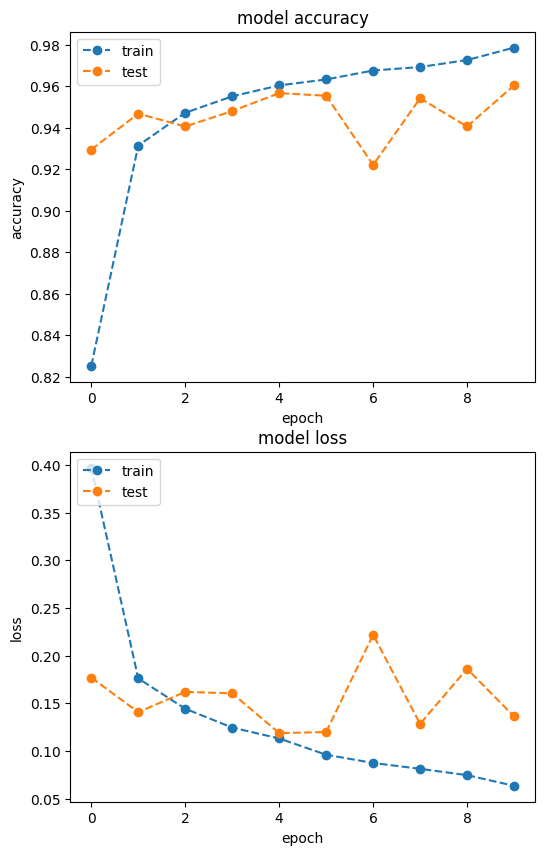

In [24]:
fix, (ax1, ax2) = plt.subplots(2, figsize=(6, 10))

# summarize history for accuracy
ax1.plot(history.history['accuracy'], "o--")
ax1.plot(history.history['val_accuracy'], "o--")
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax2.plot(history.history['loss'], "o--")
ax2.plot(history.history['val_loss'], "o--")
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
plt.show()

### Model evaluation

In [25]:
y_pred = model.predict(val_generator)
y_true = val_generator.labels

26/26 [==============================] - 10s 359ms/step


In [26]:
from sklearn import metrics
def plot_roc_curve(labels, predicted_labels):
    # Calculate the false positive rate (FPR) and true positive rate (TPR)
    fpr, tpr, _ = metrics.roc_curve(labels, predicted_labels)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = metrics.auc(fpr, tpr)

    # Plot the ROC curve
    fig, ax = plt.subplots(figsize=(8, 8), dpi=50)
    ax.plot(fpr, tpr, color='cornflowerblue', lw=2,
            label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2,
            linestyle='--')  # Diagonal line
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
    plt.legend(loc="lower right", fontsize=14)
    plt.grid(True)

    # Show the plot
    plt.show()

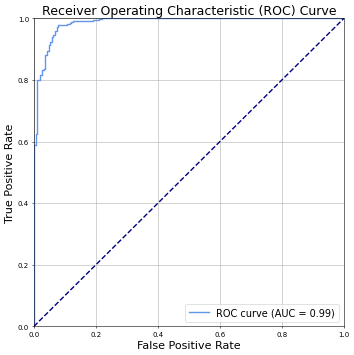

In [27]:
plot_roc_curve(y_true, y_pred)

### Transfer learning

In [28]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the DenseNet121 model but exclude the top layer (classification layer)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(320, 320, 3))

# Add your own top layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(len(label_column), activation="sigmoid")(x)

# Create the actual model
model = Model(inputs=base_model.input, outputs=outputs)
model.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 320, 320, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 326, 326, 3)          0         ['input_2[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 160, 160, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati

In [29]:
# First: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=metrics)

In [30]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
)

Epoch 1/10
131/131 [==============================] - 82s 534ms/step - loss: 0.2247 - accuracy: 0.9166 - precision: 0.9270 - recall: 0.9607 - val_loss: 0.1488 - val_accuracy: 0.9431 - val_precision: 0.9767 - val_recall: 0.9483
Epoch 2/10
131/131 [==============================] - 64s 486ms/step - loss: 0.1412 - accuracy: 0.9497 - precision: 0.9620 - recall: 0.9690 - val_loss: 0.1157 - val_accuracy: 0.9506 - val_precision: 0.9662 - val_recall: 0.9693
Epoch 3/10
131/131 [==============================] - 65s 494ms/step - loss: 0.1218 - accuracy: 0.9559 - precision: 0.9671 - recall: 0.9723 - val_loss: 0.1074 - val_accuracy: 0.9543 - val_precision: 0.9678 - val_recall: 0.9725
Epoch 4/10
131/131 [==============================] - 63s 479ms/step - loss: 0.1150 - accuracy: 0.9588 - precision: 0.9667 - recall: 0.9769 - val_loss: 0.1105 - val_accuracy: 0.9530 - val_precision: 0.9575 - val_recall: 0.9822
Epoch 5/10
131/131 [==============================] - 64s 490ms/step - loss: 0.1042 - accura

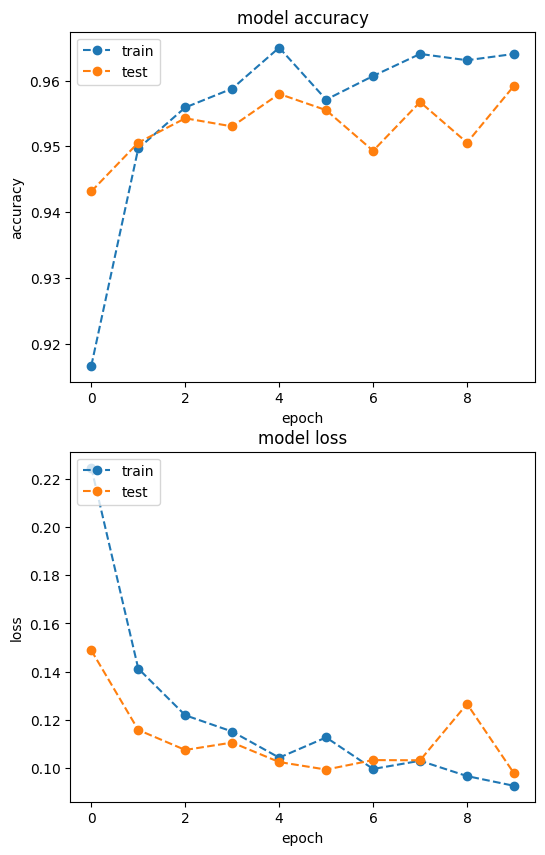

In [31]:
fix, (ax1, ax2) = plt.subplots(2, figsize=(6, 10))

# summarize history for accuracy
ax1.plot(history.history['accuracy'], "o--")
ax1.plot(history.history['val_accuracy'], "o--")
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax2.plot(history.history['loss'], "o--")
ax2.plot(history.history['val_loss'], "o--")
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
y_pred = model.predict(val_generator)
y_true = val_generator.labels

26/26 [==============================] - 12s 392ms/step


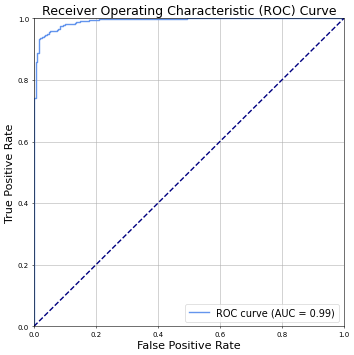

In [35]:
from sklearn import metrics
def plot_roc_curve(labels, predicted_labels):
    # Calculate the false positive rate (FPR) and true positive rate (TPR)
    fpr, tpr, _ = metrics.roc_curve(labels, predicted_labels)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = metrics.auc(fpr, tpr)

    # Plot the ROC curve
    fig, ax = plt.subplots(figsize=(8, 8), dpi=50)
    ax.plot(fpr, tpr, color='cornflowerblue', lw=2,
            label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2,
            linestyle='--')  # Diagonal line
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=18)
    plt.legend(loc="lower right", fontsize=14)
    plt.grid(True)

    # Show the plot
    plt.show()

plot_roc_curve(y_true, y_pred)

### Comment:

1. Both model show similar performance (0.99) AUC value. It shows that both model has higher True Positive rate and lower False Positive rate. Both models perform well to predict pneumonia.

2. Since custom CNN model is less complex (and has less layer) compared to the transfer learning model, it is a simple model and faster to train. The simple network layer of our CNN model can give similar performance as the transfer learning model. It is preferable to use our custom CNN model in actual prediction application, because in practice, the hardware is limitation. Hence, simpler model that deliver good performances is a good choice.

### multiclass prediction

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize images
image_generator = ImageDataGenerator(
    rescale=1.0/255
)

# Pick your label column(s)
label_column = ["virus", "bacteria", "none"] #add numerical column of infection type

# Calculate class weights
class_weights = dict(1 / train_df["label"].value_counts(normalize=True))

# Define the data generators
train_generator = image_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=path_data,
    x_col="filename",
    y_col=label_column,
    target_size=(320, 320),
    batch_size=32,
    class_mode="raw",
    color_mode= "grayscale", #grayscale bcs we chose custom cnn model --> lightweight, performs well
    class_weight=class_weights  # Specify class weights
)

val_generator = image_generator.flow_from_dataframe(
    dataframe=val_df,
    directory=path_data,
    x_col="filename",
    y_col=label_column,
    target_size=(320, 320),
    batch_size=32,
    class_mode="raw",
    color_mode="grayscale",
    shuffle=False,  # this is crucial for later evaluation!
)

Found 4173 validated image filenames.
Found 809 validated image filenames.


In [37]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Model
inputs = Input(shape=(320, 320, 1)) # resolution, greyscale
x = Conv2D(32, (3, 3), activation="relu")(inputs) # 32 kernels, with size 3x3
x = MaxPooling2D((2, 2))(x) #dimension size for comparison
x = Conv2D(64, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)

# Dense (decision) part
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(len(label_column), activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 320, 320, 1)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 318, 318, 32)      320       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 159, 159, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 157, 157, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 78, 78, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 76, 76, 128)       7385

In [38]:
# Calculate class weights
class_weights = train_df[label_column].sum(axis=0)
class_weights = class_weights.sum() / class_weights

# Ensure class weights sum up to 1
class_weights = class_weights / class_weights.sum()
class_weights

virus       0.402258
bacteria    0.220779
none        0.376963
dtype: float64

In [39]:
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf

def weighted_binary_crossentropy(class_weights):
    class_weights = tf.constant([class_weights[k] for k in sorted(class_weights.keys())], dtype=tf.float32)  # ensure class_weights is float32

    def _weighted_binary_crossentropy(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)  # ensure y_true is float32
        y_pred = tf.cast(y_pred, tf.float32)  # ensure y_pred is float32
        crossentropy = binary_crossentropy(y_true, y_pred)
        weight_vector = tf.reduce_sum(class_weights * y_true, axis=-1)
        weighted_loss = weight_vector * crossentropy
        return tf.reduce_mean(weighted_loss)

    return _weighted_binary_crossentropy


In [40]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]


learning_rate = 0.0001  # Specify your desired learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss = 'categorical_crossentropy',
              #loss=weighted_binary_crossentropy(class_weights),
              metrics=metrics)

In [41]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
)

Epoch 1/10
131/131 [==============================] - 41s 287ms/step - loss: 0.9642 - accuracy: 0.5349 - precision: 0.6754 - recall: 0.2044 - val_loss: 0.6798 - val_accuracy: 0.7330 - val_precision: 0.7781 - val_recall: 0.6588
Epoch 2/10
131/131 [==============================] - 42s 322ms/step - loss: 0.6028 - accuracy: 0.7508 - precision: 0.7822 - recall: 0.7040 - val_loss: 0.6179 - val_accuracy: 0.7120 - val_precision: 0.7345 - val_recall: 0.6873
Epoch 3/10
131/131 [==============================] - 36s 274ms/step - loss: 0.5347 - accuracy: 0.7704 - precision: 0.7918 - recall: 0.7436 - val_loss: 0.5791 - val_accuracy: 0.7775 - val_precision: 0.7876 - val_recall: 0.7565
Epoch 4/10
131/131 [==============================] - 35s 268ms/step - loss: 0.5020 - accuracy: 0.7858 - precision: 0.8025 - recall: 0.7625 - val_loss: 0.5314 - val_accuracy: 0.7886 - val_precision: 0.7992 - val_recall: 0.7726
Epoch 5/10
131/131 [==============================] - 36s 275ms/step - loss: 0.4768 - accura

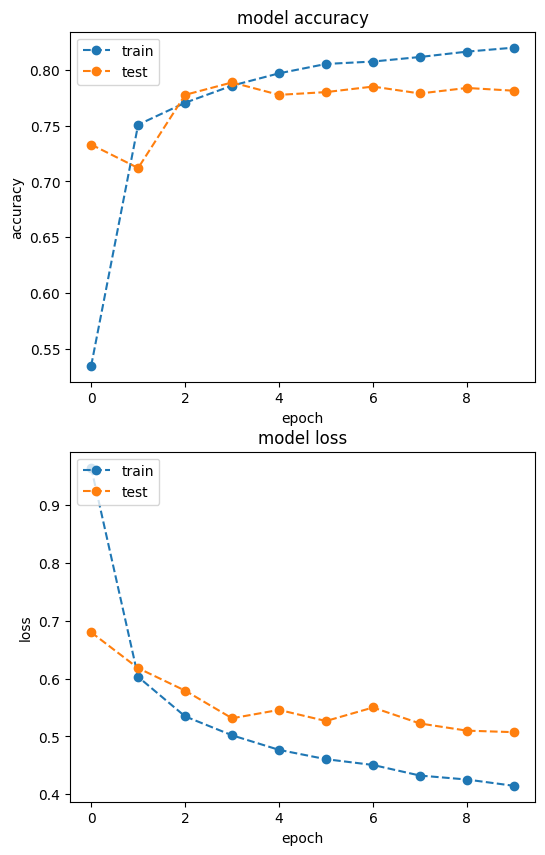

In [42]:
fix, (ax1, ax2) = plt.subplots(2, figsize=(6, 10))

# summarize history for accuracy
ax1.plot(history.history['accuracy'], "o--")
ax1.plot(history.history['val_accuracy'], "o--")
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax2.plot(history.history['loss'], "o--")
ax2.plot(history.history['val_loss'], "o--")
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
y_pred = model.predict(val_generator)
y_true = val_generator.labels

26/26 [==============================] - 5s 184ms/step


In [44]:
class_names_dict = {
    "none": "none",
    "virus": "virus",
    "bacteria": "bacteria"
}

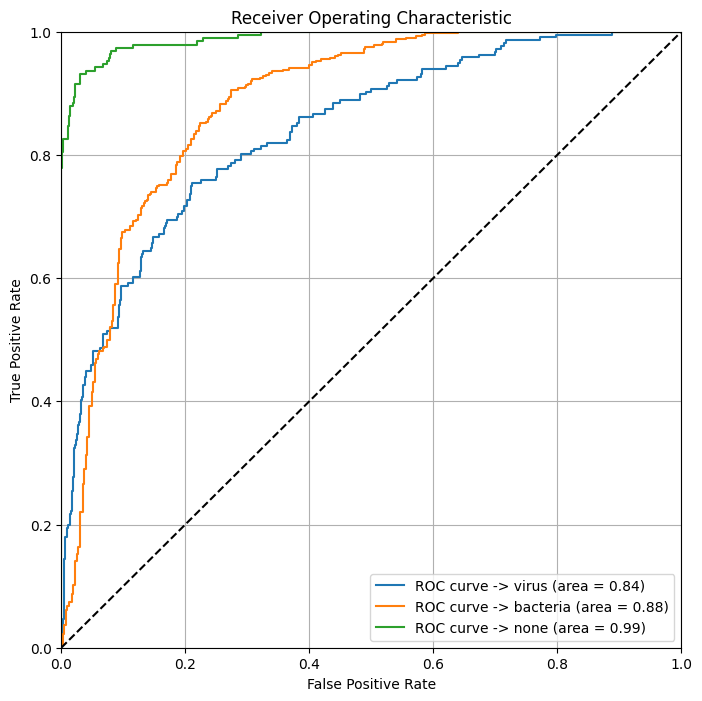

In [45]:
# Code for multi-class model
from sklearn.metrics import roc_curve, auc

# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes = label_column

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8, 8))

# Get class names
class_names = list(classes)

for i, label in enumerate(classes):
    ax.plot(fpr[i], tpr[i],
            label=f"ROC curve -> {class_names_dict[label]} (area = {roc_auc[i]:.2f})")

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")
plt.grid(True)
plt.show()

In [46]:
y_pred

array([[0.0083719 , 0.00328712, 0.9883409 ],
       [0.15275839, 0.11444502, 0.73279655],
       [0.04929898, 0.00351798, 0.947183  ],
       ...,
       [0.34513295, 0.6369837 , 0.01788331],
       [0.18658443, 0.7962181 , 0.01719761],
       [0.34467626, 0.08846775, 0.56685597]], dtype=float32)

### Data augmentation

In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize images
image_generator = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,  # Rotate images randomly within the range of 20 degrees
    width_shift_range=0.1,  # Shift the width of images randomly by up to 20% of the total width
    height_shift_range=0.1,  # Shift the height of images randomly by up to 20% of the total height
    zoom_range=0.2,  # Apply zoom transformations randomly within the range of 0.2
    #horizontal_flip=True  # Flip images horizontally randomly
)

# Pick your label column(s)
label_column = ["virus", "bacteria", "none"]  # Add numerical column of infection type

# Calculate class weights
class_weights = dict(1 / train_df["label"].value_counts(normalize=True))

# Define the data generators
train_generator = image_generator.flow_from_dataframe(
    dataframe=train_df,
    directory=path_data,
    x_col="filename",
    y_col=label_column,
    target_size=(320, 320),
    batch_size=32,
    class_mode="raw",
    color_mode="grayscale",  # Grayscale bcs we chose custom CNN model --> lightweight, performs well
    class_weight=class_weights,  # Specify class weights
    shuffle=True  # Shuffle the data for better training
)

val_generator = image_generator.flow_from_dataframe(
    dataframe=val_df,
    directory=path_data,
    x_col="filename",
    y_col=label_column,
    target_size=(320, 320),
    batch_size=32,
    class_mode="raw",
    color_mode="grayscale",
    shuffle=False  # This is crucial for later evaluation!
)


Found 4173 validated image filenames.
Found 809 validated image filenames.


In [48]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Model
inputs = Input(shape=(320, 320, 1)) # resolution, greyscale
x = Conv2D(32, (3, 3), activation="relu")(inputs) # 32 kernels, with size 3x3
x = MaxPooling2D((2, 2))(x) #dimension size for comparison
x = Conv2D(64, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)

# Dense (decision) part
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(len(label_column), activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 320, 320, 1)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 318, 318, 32)      320       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 159, 159, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 157, 157, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 78, 78, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 76, 76, 128)       7385

In [49]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]


learning_rate = 0.0001  # Specify your desired learning rate
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss = 'categorical_crossentropy',
              #loss=weighted_binary_crossentropy(class_weights),
              metrics=metrics)

In [50]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1
)

Epoch 1/10
131/131 [==============================] - 82s 581ms/step - loss: 1.0135 - accuracy: 0.4987 - precision: 0.5799 - recall: 0.1426 - val_loss: 0.7981 - val_accuracy: 0.6576 - val_precision: 0.7220 - val_recall: 0.5266
Epoch 2/10
131/131 [==============================] - 74s 563ms/step - loss: 0.7768 - accuracy: 0.6568 - precision: 0.6970 - recall: 0.5667 - val_loss: 0.7835 - val_accuracy: 0.6675 - val_precision: 0.6992 - val_recall: 0.6205
Epoch 3/10
131/131 [==============================] - 85s 648ms/step - loss: 0.7217 - accuracy: 0.6844 - precision: 0.7267 - recall: 0.6161 - val_loss: 0.7388 - val_accuracy: 0.6761 - val_precision: 0.7048 - val_recall: 0.5933
Epoch 4/10
131/131 [==============================] - 73s 558ms/step - loss: 0.7012 - accuracy: 0.6969 - precision: 0.7296 - recall: 0.6264 - val_loss: 0.6907 - val_accuracy: 0.7095 - val_precision: 0.7347 - val_recall: 0.6539
Epoch 5/10
131/131 [==============================] - 73s 559ms/step - loss: 0.6790 - accura

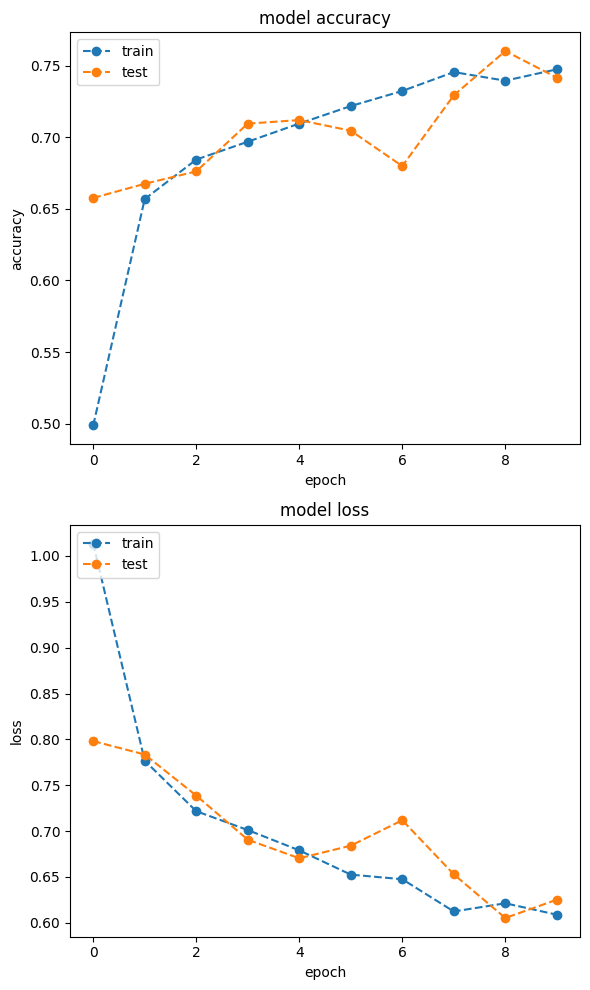

In [51]:
fix, (ax1, ax2) = plt.subplots(2, figsize=(6, 10))

# summarize history for accuracy
ax1.plot(history.history['accuracy'], "o--")
ax1.plot(history.history['val_accuracy'], "o--")
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='upper left')

# summarize history for loss
ax2.plot(history.history['loss'], "o--")
ax2.plot(history.history['val_loss'], "o--")
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'], loc='upper left')

# Adjust spacing between the subplots
plt.tight_layout()

# Save the plot as an image (e.g., PNG)
plt.savefig('training_plot.png')
plt.show()

In [52]:
y_pred = model.predict(val_generator)
y_true = val_generator.labels

26/26 [==============================] - 14s 523ms/step


In [53]:
class_names_dict = {
    "none": "none",
    "virus": "virus",
    "bacteria": "bacteria"
}

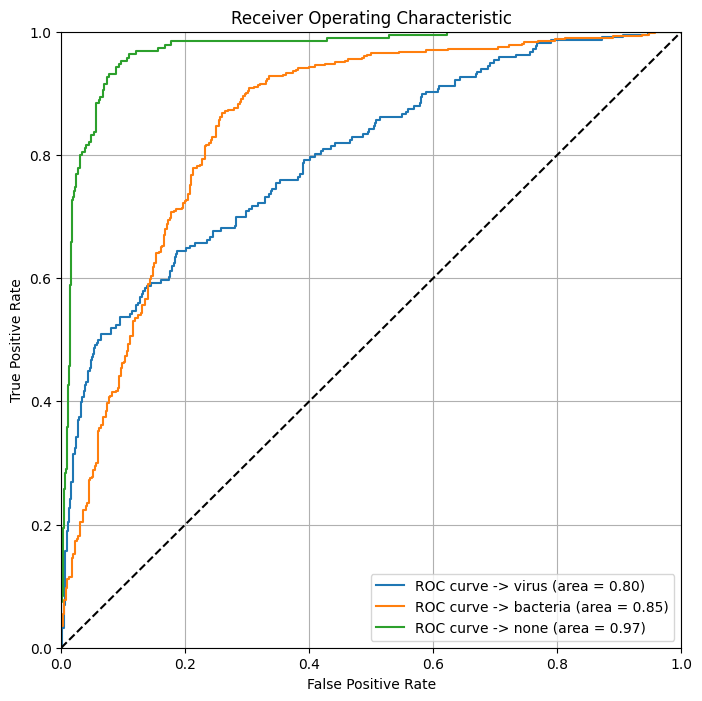

In [54]:
# Code for multi-class model
from sklearn.metrics import roc_curve, auc

# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes = label_column

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
fig, ax = plt.subplots(figsize=(8, 8))

# Get class names
class_names = list(classes)

for i, label in enumerate(classes):
    ax.plot(fpr[i], tpr[i],
            label=f"ROC curve -> {class_names_dict[label]} (area = {roc_auc[i]:.2f})")

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")
plt.grid(True)
plt.show()